# <center>Comparison of performance of KNN algorithm and linear regression - case of violent crimes committed in different communities within the United States.</center>

***

<center>Final project for Machine Learning course</center>
<center><b>Ewelina Osowska, Ewa Sobolewska</b></center>

*****

### Table of contents:

* [Dataset description](#dataset-description)
* [Data Preprocessing](#data-preprocessing)
* [Feature selection](#feature-selection)
* [Modelling](#modelling)
    * [Linear regression](#linear-regression)
    * [KNN regression](#knn-regression)
* [Validation and assessment](#validation-and-assessment)
* [Conclusions](#conclusions)

In [1]:
%autosave 0

Autosave disabled


In [3]:
# Loading libraries
import pandas as pd
import numpy as np
import warnings
from scipy import stats
from sklearn import feature_selection
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from astropy.table import Table

# General settings
pd.set_option("display.max_columns",130)
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style="whitegrid")

## Dataset description <a class="anchor" id="dataset-description"></a>

The dataset used in ...

Many variables are included so that algorithms that select or learn weights for attributes could be tested. However, clearly unrelated attributes were not included; attributes were picked if there was any plausible connection to crime (N=122), plus the attribute to be predicted (Per Capita Violent Crimes). The variables included in the dataset involve the community, such as the percent of the population considered urban, and the median family income, and involving law enforcement, such as per capita number of police officers, and percent of officers assigned to drug units. 

The per capita violent crimes variable was calculated using population and the sum of crime variables considered violent crimes in the United States: murder, rape, robbery, and assault. There was apparently some controversy in some states concerning the counting of rapes. These resulted in missing values for rape, which resulted in incorrect values for per capita violent crime. These cities are not included in the dataset. Many of these omitted communities were from the midwestern USA. 

Data is described below based on original values. All numeric data was normalized into the decimal range 0.00-1.00 using an Unsupervised, equal-interval binning method. Attributes retain their distribution and skew (hence for example the population attribute has a mean value of 0.06 because most communities are small). E.g. An attribute described as 'mean people per household' is actually the normalized (0-1) version of that value. 

The normalization preserves rough ratios of values WITHIN an attribute (e.g. double the value for double the population within the available precision - except for extreme values (all values more than 3 SD above the mean are normalized to 1.00; all values more than 3 SD below the mean are nromalized to 0.00)). 

However, the normalization does not preserve relationships between values BETWEEN attributes (e.g. it would not be meaningful to compare the value for whitePerCap with the value for blackPerCap for a community) 

A limitation was that the LEMAS survey was of the police departments with at least 100 officers, plus a random sample of smaller departments. For our purposes, communities not found in both census and crime datasets were omitted. Many communities are missing LEMAS data. 




The Law Enforcement Management and Administrative Statistics (LEMAS) survey collects data from a nationally representative sample of state, county, and local law enforcement agencies in the United States. For most questions, a reference date of June 30, 2016 was used.

The 2016 LEMAS sample design called for the survey questionnaire to be sent to 3,499 general purpose state and local law enforcement agencies. The design called for all agencies employing 100 or sworn personnel to be included with certainty (self-representing), and for smaller agencies to be sampled from strata based on number of sworn officers and type of agency.

A total of 27 local police departments were determined to be out-of-scope for the survey because they were special jurisdiction agencies, had closed, had outsourced their operations, or were operating on a part-time basis. The final mail out total of 3,472 agencies included 2,613 local police departments, 810 sheriffs' offices, and the 49 state agencies.

A total of 2,780 agencies responded to the LEMAS questionnaire, for a response rate of 80%. The final database includes responses from 2,136 local police departments, 600 sheriffs' offices, and 49 state law enforcement agencies (including partial responses from 5 primary state police agencies). The overall response rate for local police departments was 82%, 74% for sheriffs' offices, and 90% for state law enforcement agencies.

## Data preprocessing <a class="anchor" id="data-preprocessing"></a>

Before each step data is saved in reproducible form of a pickle. The data has 1994 observations and 128 columns. Each observation states for different communities. The steps necessary to get the pickle used below are attached in the supplement.

In [4]:
mydata = pd.read_pickle("dataset/mydata.p")

In [5]:
mydata.shape

(1994, 127)

In [6]:
mydata.head()

,state,county,community,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,0.49,0.44,0.75,0.65,0.54,0.83,0.65,0.85,0.86,0.03,0.33,0.02,0.11,0.20,0.30,0.31,0.05,0.08,0.11,0.11,0.81,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.

In the dataset there are multiple missing values. They can be divided into three categories. Columns _county_ and _community_ don't have id numbers assigned, however these are only informational values and it doesn't affect the modelling process. Thus these columns may be ommitted without further consequences. The second category are columns that have 1675 missing values. They come from the 1990 LEMAS survey (The Law Enforcement Management and Administrative Statistics) and were not provided originally. Thus the filling of the variables is about 16%, we decided to discard these features from the analysis. The last category is one missing value in _OtherPerCap_ column. There are too few missing values in the column and also there no other important missing values in the row, so we cannot omit it. Taken steps will be explained later on.

In [7]:
print(mydata.isnull().sum()[mydata.isnull().sum()>1])

county                  1174
community               1177
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
PolicAveOTWorked        1675
PolicCars               1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
LemasGangUnitDeploy     1675
PolicBudgPerPop         1675
dtype: int64


In [8]:
mydata = mydata.drop(["county", "community"], axis=1)

In [9]:
mydata = mydata.drop(mydata.columns[mydata.apply(lambda col: col.isnull().sum() > 1)], axis=1)

There are many missings inputation methods. As a first step, we checked the distribution of the variable. It seems that its values are aggregated between 0.17 (Q1) and 0.36 (Q3) overall and between 0.15 (Q1) and 0.315 (Q3) only in Mississippi - the state within which the missing value occurs. Thus we decided to fill the value with the median in this state.

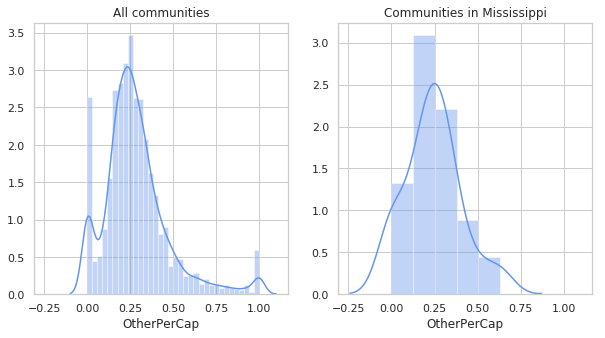

In [10]:
mydata_nonans = mydata.dropna()

f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.distplot(mydata_nonans.OtherPerCap, color="cornflowerblue", ax=axes[0]).set_title("All communities")
sns.distplot(mydata_nonans[mydata_nonans.state==28].OtherPerCap, color="cornflowerblue", ax=axes[1]).set_title("Communities in Mississippi")
plt.show()

In [11]:
mydata[mydata.OtherPerCap.isna()]

,state,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
130,28,Natchezcity,0.02,0.38,0.98,0.22,0.01,0.01,0.44,0.4,0.27,0.58,0.0,0.0,0.09,0.24,0.35,0.31,0.65,0.78,0.49,0.12,0.18,0.32,0.15,0.08,0.37,NaN,0.63,0.05,0.85,0.54,0.54,0.29,0.86,0.19,0.31,0.53,0.37,0.51,0.62,0.44,0.62,0.65,0.49,0.2,0.2,0.13,0.19,0.59,0.5,0.04,0.85,0.0,0.22,0.16,0.13,0.11,0.01,0.0,0.0,0.0,0.98,0.02,0.28,0.24,0.4,0.36,0.47,0.52,0.17,0.46,0.5,0.05,0.52,0.55,0.31,0.68,0.38,0.51,0.55,0.06,0.06,0.08,0.0,0.06,0.11,0.11,0.6,0.44,0.76,0.0,0.0,0.01,0.84,0.7,0.83,0.77,0.04,0.12,0.05,0.0,0.23


In [12]:
mydata.OtherPerCap.quantile([0.25, 0.5, 0.75])

0.25    0.17
0.50    0.25
0.75    0.36
Name: OtherPerCap, dtype: float64

In [13]:
mydata[mydata.state==28].OtherPerCap.quantile([0.25, 0.5, 0.75])

0.25    0.1400
0.50    0.2300
0.75    0.3225
Name: OtherPerCap, dtype: float64

In [14]:
mydata.loc[130, "OtherPerCap"] = 0.23

In [15]:
mydata.to_pickle("dataset/mydata_step1.p")

## Feature selection <a class="anchor" id="feature-selection"></a>

Next step of the analysis will be determining which variables to include in the final model. First of all we checked teh variables distributions and its relationship with dependent variable. It occured that some variables obtain few levels of values while being continuous like for example _pctUrban_ and _MedNumBR_. Thus we decided to discretize them. Also many variables seem to have low variance and this lead us to conduct analysis of near zero variance. Plots for all variables can be found in the supplement code.

In [16]:
mydata = pd.read_pickle("dataset/mydata_step1.p")
numCols = ['population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome','pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst','pctWRetire','medFamInc','perCapInc','whitePerCap','blackPerCap','indianPerCap','AsianPerCap','OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad','PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf','MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg','NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10','PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc','PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal','OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent','MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState','PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LandArea', 'PopDens', 'PctUsePubTrans', 'LemasPctOfficDrugUn']
target_var = 'ViolentCrimesPerPop'

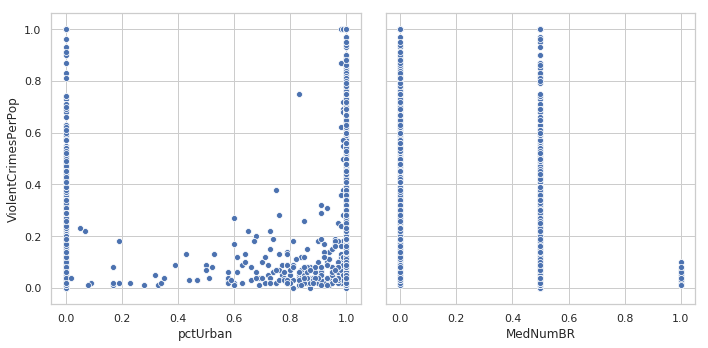

In [17]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.scatterplot(mydata["pctUrban"], mydata[target_var], ax=axes[0])
sns.scatterplot(mydata["MedNumBR"], mydata[target_var], ax=axes[1])
plt.tight_layout()
plt.show()

As stated before, variables _pctUrban_ and _MedNumBR_ will be discretized. In case of first variable, we will create two bins taking 0.5 as threshold between two levels. In case of second variable, we addidionaly conducted analysis of quantiles in order to decide whether third bin should be considered. It turns out that even in the 98th percentile, the value is still 0.5 so only two bins were created. 

In [18]:
mydata.loc[mydata.pctUrban<0.5, "pctUrban"] = 0
mydata.loc[mydata.pctUrban>=0.5, "pctUrban"] = 1

In [19]:
mydata.MedNumBR.quantile([0.25, 0.5, 0.75, 0.98])

0.25    0.0
0.50    0.5
0.75    0.5
0.98    0.5
Name: MedNumBR, dtype: float64

In [20]:
mydata.loc[mydata.MedNumBR<0.5, "MedNumBR"]=0
mydata.loc[mydata.MedNumBR>=0.5, "MedNumBR"]=1

Because of low variance visible on scatterplots, additional near zero variance was performed. A threshold of 0.02 was set resulting in 8 potentially irrelevant variables. Distributions of these variables are visible below. At this stage we will not omit these variables. Before making decision on dropping those variables, we want to check its correlation with dependent variable and mutual information.

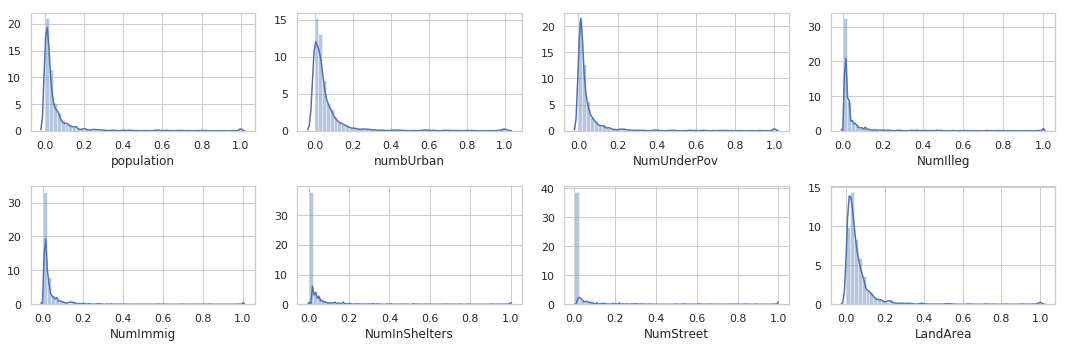

In [21]:
selector = feature_selection.VarianceThreshold(0.02)
selector.fit_transform(mydata[numCols])

f, axes = plt.subplots(2, 4, figsize=(15, 5))
i = 0
nearzerovar = [item for item in np.arange(100) if (item not in selector.get_support(True))]
for col in nearzerovar:
    sns.distplot(mydata[numCols[col]], ax=axes[i//4, i%4])
    i += 1
plt.tight_layout()
plt.show()

Spearman correlation was calculated. Assuming correlation coefficient threshold to be 0.5, 24 variables were returned. The result of correlation was saved into filterdf dataframe.

In [22]:
filterlist = []
for colname in numCols:
    spearman = stats.spearmanr(mydata[colname], mydata[target_var])
    filterlist.append([colname, spearman.correlation, spearman.pvalue])

In [23]:
filterdf = pd.DataFrame(filterlist, columns=('name', 'spearman_coef', 'spearman_pval'))
filterdf.index = filterdf.name
filterdf = filterdf.drop('name', axis=1)

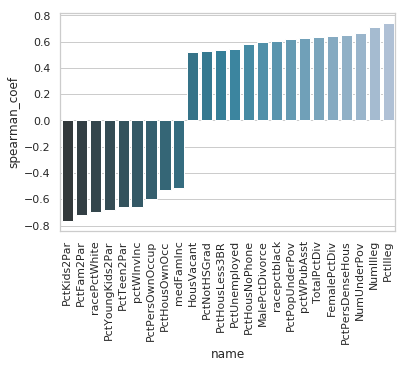

In [24]:
cutoff = 0.5
data = filterdf.spearman_coef[filterdf.spearman_coef.abs()>cutoff].sort_values()
ax = sns.barplot(data.index, y=data, palette="PuBuGn_d")
plt.xticks(rotation=90)
plt.show()

As to mutual information, we used mutual_info_regression function from sklearn library. Higher values indicate higher dependency. The results are saved in midf dataframe.

In [25]:
minfos=[]
for var in numCols:
    minfos.append(feature_selection.mutual_info_regression(mydata[var].astype(float).values.reshape(-1,1), mydata["ViolentCrimesPerPop"].astype(float).values)[0])

In [26]:
midf = list(zip(minfos, numCols))
midf.sort(reverse=True)
midf = pd.DataFrame(midf, columns=['MI', "name"])
midf.index = midf.name
midf = midf.drop("name", axis=1)

Dataframe combining results from correlation and mutual information was saved into allfeaturedf dataframe.

In [27]:
allfeaturedf = filterdf.join(midf)
allfeaturedf.to_pickle("dataset/allfeaturedf.p")

In [28]:
col = "spearman_coef"
allfeaturedf["spearmanres"] = 0
borderval = allfeaturedf[allfeaturedf.spearman_pval<0.05].abs().sort_values(col, ascending=False).spearman_coef.iloc[30,]
allfeaturedf.loc[(allfeaturedf.spearman_coef<borderval) & (allfeaturedf.spearman_pval<0.05),"spearmanres"] = 1

In [29]:
col = "MI"
allfeaturedf["MIres"] = 0
borderval = allfeaturedf.sort_values(col, ascending=False).MI.iloc[30,]
allfeaturedf.loc[allfeaturedf.MI>borderval,"MIres"] = 1

In [30]:
allfeaturedf.loc[(allfeaturedf.spearmanres==1) & (allfeaturedf.MIres==1),:]

,spearman_coef,spearman_pval,MI,spearmanres,MIres
name,,,,,
racePctWhite,-0.697328,2.011768e-290,0.314126,1,1
racePctHisp,0.324374,4.461401e-50,0.120233,1,1
agePct16t24,0.323464,8.622907e-50,0.124574,1,1
medIncome,-0.482170,1.297885e-116,0.162426,1,1
pctWInvInc,-0.658113,8.254017e-248,0.283717,1,1
medFamInc,-0.513162,2.198249e-134,0.193129,1,1
blackPerCap,-0.311354,4.469109e-46,0.143585,1,1
PctFam2Par,-0.722948,3.260833e-322,0.381070,1,1
PctKids2Par,-0.763127,0.000000e+00,0.478911,1,1


In [31]:
finalcols = allfeaturedf.loc[(allfeaturedf.spearmanres==1) & (allfeaturedf.MIres==1),:].index.tolist()

In [32]:
finalcols

['racePctWhite',
 'racePctHisp',
 'agePct16t24',
 'medIncome',
 'pctWInvInc',
 'medFamInc',
 'blackPerCap',
 'PctFam2Par',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctPersOwnOccup',
 'PctHousOwnOcc']

### Terstowa regresja

In [35]:
y = mydata[target_var]
X = mydata[finalcols]
X = sm.add_constant(X)
np.sqrt(sm.OLS(y, X).fit().mse_model)

2.260988860354689

In [36]:
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.614
Model:                             OLS   Adj. R-squared:                  0.612
Method:                  Least Squares   F-statistic:                     242.6
Date:                 Sun, 05 May 2019   Prob (F-statistic):               0.00
Time:                         21:04:42   Log-Likelihood:                 1025.8
No. Observations:                 1994   AIC:                            -2024.
Df Residuals:                     1980   BIC:                            -1945.
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8800      0.022     40.800      0.000       0.838       0.922
racePctWhite        -0.2253      0.025     -9.015      0.000      -0.274      -0.176
racePctHisp          0.0444      0.019      2.319      0.021       0.007       0.082
agePct16t24         -0.1093      0.025     -4.447      0.000      -0.157      -0.061
medIncome            0.1626      0.102      1.601      0.110      -0.037       0.362
pctWInvInc          -0.0842      0.043     -1.964      0.050      -0.168      -0.000
medFamInc            0.0231      0.109      0.213      0.832      -0.190       0.236
blackPerCap         -0.0422      0.026     -1.614      0.107      -0.094       0.009
PctFam2Par           0.0284      0.140      0.203      0.839      -0.246       0.303
PctKids2Par         -0.6703      0.132     -5.081      0.000      -0.929      -0.412
PctYoungKids2Par    -0.0075      0.045     -0.167      0.868      -0.095       0.081
PctTeen2Par         -0.0158      0.044     -0.356      0.722      -0.102       0.071
PctPersOwnOccup     -0.1528      0.114     -1.339      0.181      -0.376       0.071
PctHousOwnOcc        0.0795      0.115      0.691      0.490      -0.146       0.305
==============================================================================
Omnibus:                      338.313   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              895.882
Skew:                           0.907   Prob(JB):                    2.89e-195
Kurtosis:                       5.737   Cond. No.                         128.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## a co jak zrobimy za pomocą forward selection?

In [37]:
# https://planspace.org/20150423-forward_selection_with_statsmodels/ but a bit edited to our needs
def forward_selected(data, response):
    y = mydata[response]
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            X = mydata[selected + [candidate]]
            X = sm.add_constant(X)
            score = sm.OLS(y, X).fit().pvalues[candidate]
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if 0.05 > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        if 0.05<best_new_score:
            break
    X = mydata[selected + [candidate]]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print("The optimal model consists of {} variables.".format(len(selected)))
    class myresult:
        pass
    myresult.model = model
    myresult.selected=selected
    return myresult

In [38]:
mydataols = mydata.drop(["communityname", "state"], axis=1)
fs = forward_selected(mydataols, target_var)

The optimal model consists of 27 variables.


In [39]:
fs.model.params

const                    0.650214
PctIlleg                 0.145470
FemalePctDiv            -0.139783
racePctWhite            -0.093292
HousVacant               0.268670
PctKids2Par             -0.400970
PctWorkMom              -0.134101
pctUrban                 0.041347
NumStreet                0.193274
numbUrban               -0.194857
MalePctDivorce           0.205486
PctPersDenseHous         0.171828
racepctblack             0.180687
PctPopUnderPov          -0.171368
MedOwnCostPctIncNoMtg   -0.089146
OtherPerCap              0.049223
pctWFarmSelf             0.028466
MedRentPctHousInc        0.059451
RentLowQ                -0.269146
MedRent                  0.251904
pctWRetire              -0.117231
pctWWage                -0.220096
whitePerCap             -0.387921
PctEmploy                0.142967
perCapInc                0.329840
PctEmplManu             -0.035230
PctVacantBoarded         0.049550
PctVacMore6Mos          -0.046778
PersPerFam              -0.000184
dtype: float64

In [40]:
finalcols_MIcorr = set(finalcols)

In [41]:
finalcols_fs = set(fs.selected)

In [42]:
print("""Columns found by filter not by forward selection: {} \n
      Columns found by forward selection not by filter: {} \n
      Columns found by both {} \n""".format(finalcols_MIcorr-finalcols_fs, finalcols_fs-finalcols_MIcorr, finalcols_MIcorr&finalcols_fs))

Columns found by filter not by forward selection: {'PctFam2Par', 'medFamInc', 'medIncome', 'PctYoungKids2Par', 'PctTeen2Par', 'pctWInvInc', 'agePct16t24', 'blackPerCap', 'PctHousOwnOcc', 'PctPersOwnOccup', 'racePctHisp'} 

      Columns found by forward selection not by filter: {'PctIlleg', 'PctVacantBoarded', 'OtherPerCap', 'FemalePctDiv', 'PctEmploy', 'pctWWage', 'PctEmplManu', 'RentLowQ', 'PctPersDenseHous', 'pctUrban', 'PctPopUnderPov', 'MedRent', 'perCapInc', 'HousVacant', 'PctWorkMom', 'numbUrban', 'MedOwnCostPctIncNoMtg', 'MedRentPctHousInc', 'NumStreet', 'whitePerCap', 'PctVacMore6Mos', 'MalePctDivorce', 'racepctblack', 'pctWFarmSelf', 'pctWRetire'} 

      Columns found by both {'PctKids2Par', 'racePctWhite'} 



# Testowa regresja dla forward selection

In [43]:
y = mydata[target_var]
X = mydata[list(finalcols_fs)]
X = sm.add_constant(X)
np.sqrt(sm.OLS(y, X).fit().mse_model)

1.6488376309232557

In [44]:
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.679
Model:                             OLS   Adj. R-squared:                  0.674
Method:                  Least Squares   F-statistic:                     153.7
Date:                 Sun, 05 May 2019   Prob (F-statistic):               0.00
Time:                         21:05:51   Log-Likelihood:                 1207.3
No. Observations:                 1994   AIC:                            -2359.
Df Residuals:                     1966   BIC:                            -2202.
Df Model:                           27                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.6502      0.093      6.972      0.000       0.467       0.833
PctIlleg                  0.1455      0.039      3.690      0.000       0.068       0.223
PctVacantBoarded          0.0495      0.019      2.561      0.011       0.012       0.087
OtherPerCap               0.0492      0.017      2.816      0.005       0.015       0.084
FemalePctDiv             -0.1398      0.056     -2.507      0.012      -0.249      -0.030
PctEmploy                 0.1430      0.055      2.610      0.009       0.036       0.250
pctWWage                 -0.2201      0.045     -4.928      0.000      -0.308      -0.133
PctEmplManu              -0.0352      0.018     -2.006      0.045      -0.070      -0.001
RentLowQ                 -0.2691      0.052     -5.220      0.000      -0.370      -0.168
PctPersDenseHous          0.1717      0.034      5.073      0.000       0.105       0.238
racePctWhite             -0.0933      0.045     -2.064      0.039      -0.182      -0.005
PctPopUnderPov           -0.1713      0.041     -4.156      0.000      -0.252      -0.090
MedRent                   0.2519      0.057      4.431      0.000       0.140       0.363
perCapInc                 0.3299      0.141      2.332      0.020       0.053       0.607
HousVacant                0.2687      0.050      5.333      0.000       0.170       0.368
PctWorkMom               -0.1341      0.024     -5.518      0.000      -0.182      -0.086
pctWRetire               -0.1172      0.030     -3.890      0.000      -0.176      -0.058
MedOwnCostPctIncNoMtg    -0.0892      0.019     -4.686      0.000      -0.126      -0.052
numbUrban                -0.1949      0.063     -3.110      0.002      -0.318      -0.072
MedRentPctHousInc         0.0595      0.027      2.216      0.027       0.007       0.112
PctKids2Par              -0.4010      0.066     -6.088      0.000      -0.530      -0.272
NumStreet                 0.1933      0.040      4.833      0.000       0.115       0.272
whitePerCap              -0.3879      0.130     -2.993      0.003      -0.642      -0.134
PctVacMore6Mos           -0.0468      0.022     -2.127      0.034      -0.090      -0.004
MalePctDivorce            0.2055      0.050      4.134      0.000       0.108       0.303
racepctblack              0.1807      0.038      4.789      0.000       0.107       0.255
pctWFarmSelf              0.0285      0.019      1.523      0.128      -0.008       0.065
pctUrban                  0.0413      0.009      4.736      0.000       0.024       0.058
==============================================================================
Omnibus:                      390.957   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1244.543
Skew:                           0.977   Prob(

### usuwanie nieistotnej zmiennej

In [62]:
finalcols_fs2 = list(finalcols_fs)
finalcols_fs2.remove('pctWFarmSelf')

['PctIlleg',
 'PctVacantBoarded',
 'OtherPerCap',
 'FemalePctDiv',
 'PctEmploy',
 'pctWWage',
 'PctEmplManu',
 'RentLowQ',
 'PctPersDenseHous',
 'racePctWhite',
 'PctPopUnderPov',
 'MedRent',
 'perCapInc',
 'HousVacant',
 'PctWorkMom',
 'pctWRetire',
 'MedOwnCostPctIncNoMtg',
 'numbUrban',
 'MedRentPctHousInc',
 'PctKids2Par',
 'NumStreet',
 'whitePerCap',
 'PctVacMore6Mos',
 'MalePctDivorce',
 'racepctblack',
 'pctUrban']

In [63]:
y = mydata[target_var]
X = mydata[finalcols_fs2]
X = sm.add_constant(X)
np.sqrt(sm.OLS(y, X).fit().mse_model)

1.6797773476660514

In [64]:
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.678
Model:                             OLS   Adj. R-squared:                  0.674
Method:                  Least Squares   F-statistic:                     159.4
Date:                 Sun, 05 May 2019   Prob (F-statistic):               0.00
Time:                         21:12:23   Log-Likelihood:                 1206.2
No. Observations:                 1994   AIC:                            -2358.
Df Residuals:                     1967   BIC:                            -2207.
Df Model:                           26                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.6580      0.093      7.064      0.000       0.475       0.841
PctIlleg                  0.1447      0.039      3.671      0.000       0.067       0.222
PctVacantBoarded          0.0505      0.019      2.614      0.009       0.013       0.088
OtherPerCap               0.0482      0.017      2.757      0.006       0.014       0.082
FemalePctDiv             -0.1392      0.056     -2.495      0.013      -0.249      -0.030
PctEmploy                 0.1425      0.055      2.601      0.009       0.035       0.250
pctWWage                 -0.2227      0.045     -4.988      0.000      -0.310      -0.135
PctEmplManu              -0.0401      0.017     -2.318      0.021      -0.074      -0.006
RentLowQ                 -0.2743      0.051     -5.330      0.000      -0.375      -0.173
PctPersDenseHous          0.1738      0.034      5.137      0.000       0.107       0.240
racePctWhite             -0.0948      0.045     -2.098      0.036      -0.183      -0.006
PctPopUnderPov           -0.1625      0.041     -3.979      0.000      -0.243      -0.082
MedRent                   0.2533      0.057      4.457      0.000       0.142       0.365
perCapInc                 0.3197      0.141      2.262      0.024       0.042       0.597
HousVacant                0.2679      0.050      5.316      0.000       0.169       0.367
PctWorkMom               -0.1285      0.024     -5.348      0.000      -0.176      -0.081
pctWRetire               -0.1255      0.030     -4.232      0.000      -0.184      -0.067
MedOwnCostPctIncNoMtg    -0.0922      0.019     -4.874      0.000      -0.129      -0.055
numbUrban                -0.1962      0.063     -3.130      0.002      -0.319      -0.073
MedRentPctHousInc         0.0561      0.027      2.098      0.036       0.004       0.109
PctKids2Par              -0.3872      0.065     -5.933      0.000      -0.515      -0.259
NumStreet                 0.1934      0.040      4.833      0.000       0.115       0.272
whitePerCap              -0.3743      0.129     -2.893      0.004      -0.628      -0.121
PctVacMore6Mos           -0.0450      0.022     -2.049      0.041      -0.088      -0.002
MalePctDivorce            0.2038      0.050      4.100      0.000       0.106       0.301
racepctblack              0.1778      0.038      4.718      0.000       0.104       0.252
pctUrban                  0.0383      0.009      4.507      0.000       0.022       0.055
==============================================================================
Omnibus:                      390.939   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1254.418
Skew:                           0.974   Prob(JB):                    4.04e-273
Kurtosis:                       6.362   Cond. No.       

In [ ]:
f, axes = plt.subplots(9, 3, figsize=(15, 35))
i = 0
for col in range(len(finalcols_fs)):
    sns.distplot(mydata[numCols[col]], ax=axes[i//3, i%3])
    i += 1
plt.tight_layout()
plt.show()

# BOXCOX

In [65]:
mydata_boxcox = mydata

In [66]:
# http://dataunderthehood.com/2018/01/15/box-cox-transformation-with-python/
def normtesttab(x):
    nm_value, nm_p = stats.normaltest(x)
    jb_value, jb_p = stats.jarque_bera(x)
    data_rows = [('D’Agostino-Pearson', nm_value, nm_p),
                 ('Jarque-Bera', jb_value, jb_p)]
    t = Table(rows=data_rows, names=('Test name', 'Statistic', 'p-value'), 
              meta={'name': 'normal test table'},
          dtype=('S25', 'f8', 'f8'))
    return nm_p, jb_p, t

In [67]:
for col in finalcols_fs|finalcols_MIcorr:
    xt, maxlog, interval = stats.boxcox(mydata[col]+1, alpha=0.05)
    if ((normtesttab(mydata[col]+1)[0]>0.05)and(normtesttab(mydata[col]+1)[1]>0.05)):
        pass
    if ((normtesttab(xt)[0]>=0.05)and(normtesttab(xt)[1]>=0.05)):
        if ((normtesttab(mydata[col]+1)[0]<0.05) and (normtesttab(mydata[col]+1)[1]<0.05)):
            mydata_boxcox[col] = xt

In [70]:
y = mydata_boxcox[target_var]
X = mydata_boxcox[list(finalcols_fs2)]
X = sm.add_constant(X)
np.sqrt(sm.OLS(y, X).fit().mse_model)

1.6777411059301026

In [71]:
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.676
Model:                             OLS   Adj. R-squared:                  0.672
Method:                  Least Squares   F-statistic:                     158.2
Date:                 Sun, 05 May 2019   Prob (F-statistic):               0.00
Time:                         21:17:47   Log-Likelihood:                 1201.1
No. Observations:                 1994   AIC:                            -2348.
Df Residuals:                     1967   BIC:                            -2197.
Df Model:                           26                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.6410      0.100      6.386      0.000       0.444       0.838
PctIlleg                  0.1564      0.040      3.944      0.000       0.079       0.234
PctVacantBoarded          0.0491      0.019      2.530      0.011       0.011       0.087
OtherPerCap               0.0485      0.018      2.771      0.006       0.014       0.083
FemalePctDiv             -0.1253      0.055     -2.264      0.024      -0.234      -0.017
PctEmploy                 0.0888      0.040      2.201      0.028       0.010       0.168
pctWWage                 -0.1943      0.044     -4.428      0.000      -0.280      -0.108
PctEmplManu              -0.0338      0.017     -1.948      0.052      -0.068       0.000
RentLowQ                 -0.2815      0.052     -5.379      0.000      -0.384      -0.179
PctPersDenseHous          0.1789      0.034      5.218      0.000       0.112       0.246
racePctWhite             -0.0962      0.047     -2.050      0.041      -0.188      -0.004
PctPopUnderPov           -0.1580      0.044     -3.582      0.000      -0.245      -0.072
MedRent                   0.2436      0.056      4.355      0.000       0.134       0.353
perCapInc                 0.8065      0.467      1.728      0.084      -0.109       1.722
HousVacant                0.2628      0.051      5.189      0.000       0.163       0.362
PctWorkMom               -0.0771      0.015     -5.176      0.000      -0.106      -0.048
pctWRetire               -0.1831      0.049     -3.713      0.000      -0.280      -0.086
MedOwnCostPctIncNoMtg    -0.0857      0.019     -4.546      0.000      -0.123      -0.049
numbUrban                -0.2011      0.063     -3.201      0.001      -0.324      -0.078
MedRentPctHousInc         0.0576      0.026      2.193      0.028       0.006       0.109
PctKids2Par              -0.3716      0.065     -5.742      0.000      -0.499      -0.245
NumStreet                 0.1897      0.040      4.725      0.000       0.111       0.268
whitePerCap              -0.9382      0.416     -2.256      0.024      -1.754      -0.123
PctVacMore6Mos           -0.0433      0.022     -1.962      0.050      -0.087   -9.46e-06
MalePctDivorce            0.2027      0.050      4.084      0.000       0.105       0.300
racepctblack              0.1699      0.038      4.501      0.000       0.096       0.244
pctUrban                  0.0384      0.009      4.504      0.000       0.022       0.055
==============================================================================
Omnibus:                      395.712   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1262.741
Skew:                           0.988   Prob(JB):                    6.30e-275
Kurtosis:                       6.361   Cond. No.       

### dla tych 30 co zostaly zobaczyc ktore sa jakie wg plota ponizej

blablabla dalej

In [ ]:
def plot_eval(methods, dataframe, response):
    y = mydata[response]
    if type(methods)==str:
        methods = [methods]
    results = {}
    for method in methods:
        dataframe.sort_values(method)
        result_temp = []
        selected = []
        for column in dataframe.head(25).index:
            selected = selected + [column]
            X = mydata[selected]
            X = sm.add_constant(X)
            scoreR2 = sm.OLS(y, X).fit().rsquared_adj
            scoreMSE = sm.OLS(y,X).fit().mse_model
            scoreAIC = sm.OLS(y,X).fit().aic
            scoreBIC = sm.OLS(y,X).fit().bic
            result_temp.append([scoreR2, scoreMSE, scoreAIC, scoreBIC])
        results[method]=pd.DataFrame(result_temp, columns=["R2", "MSE", "AIC", "BIC"])
    return results

In [ ]:
for col in res['MI'].columns:
    sns.lineplot(res['MI'].index, res['MI'][col], palette="Blues")
    plt.show()

In [ ]:
x1=x.reshape(500)
x1=(x1 - x1.mean()) / (x1.max() - x1.min())
xt1=xt.reshape(500)
xt1=(xt1 - xt1.mean()) / (xt1.max() - xt1.min())
sns.kdeplot(x1, shade=True, label="Raw (normalized)" );
sns.kdeplot(xt1, shade=True, label="Transformed (normalized)" );

### corrplot

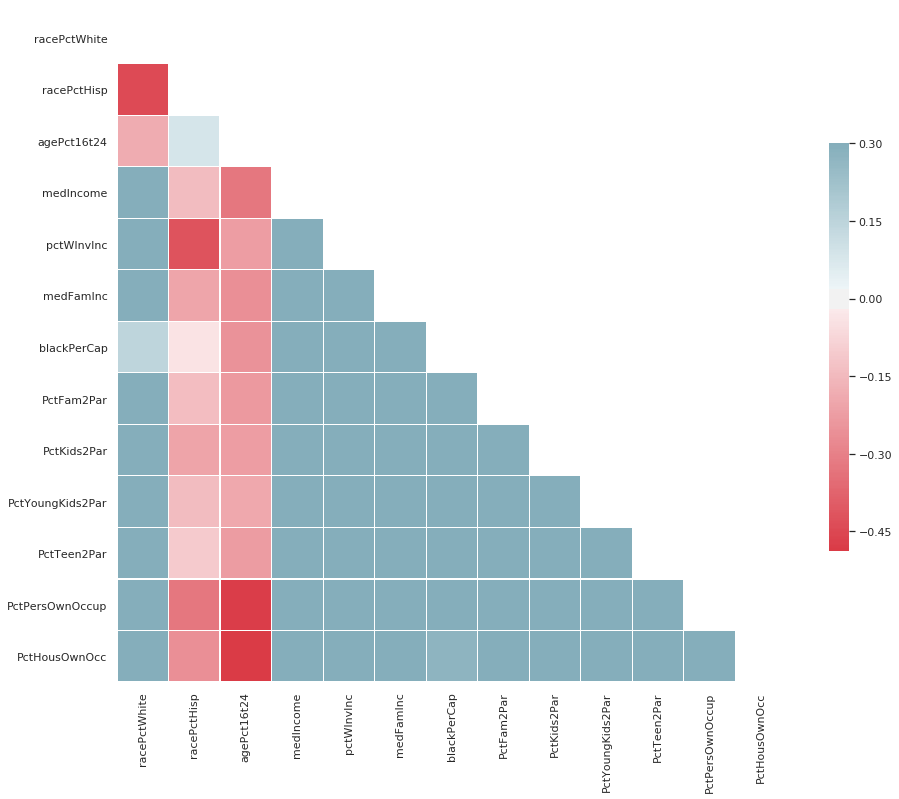

In [72]:
mydata_new = mydata[allfeaturedf.loc[(allfeaturedf.spearmanres==1) & (allfeaturedf.MIres==1),:].index.tolist()]
corr = mydata_new.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
# sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.2, cbar_kws={"shrink": .5})

### Forward/reverse selection

## Modelling <a class="anchor" id="modelling"></a>

### Linear regression <a class="anchor" id="linear-regression"></a>

### KNN regression <a class="anchor" id="knn-regression"></a>

## Validation and assessment <a class="anchor" id="validation-and-assessment"></a>

## Conclusions <a class="anchor" id="conclusions"></a>